In [22]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import pickle
import numpy as np
import pandas as pd
from collections import OrderedDict
import re
import os
# os.chdir(r'C:\Users\dexin\PycharmProjects\eeg\PhysioLabXR')

In [23]:
def align_and_preprocess_data(eeg_df, events_df):
    eeg_timestamps = eeg_df['Timestamp'].values
    event_timestamps = events_df['absoluteTime'].values

    valid_events = events_df[events_df['conditionType'] == 'Sweyepe']
    print(f"Found {len(valid_events)} Sweyepe events")

    aligned_data = []
    aligned_conditions = []

    pre_window = int(0.5 * 256)  # 0.5s before at 256Hz
    post_window = int(0.5 * 256)  # 0.5s after

    for _, event in valid_events.iterrows():
        evt_time = event['absoluteTime']
        condition = event['DesignMatrixCondition']

        if pd.isna(condition):
            continue

        closest_idx = np.argmin(np.abs(eeg_timestamps - evt_time))

        if closest_idx >= pre_window and closest_idx + post_window < len(eeg_timestamps):
            window_data = eeg_df.iloc[closest_idx-pre_window:closest_idx+post_window]
            aligned_data.append(window_data.filter(like='Channel').values)
            aligned_conditions.append(int(condition))

    if not aligned_data:
        raise ValueError("No valid events found after alignment")

    return np.array(aligned_data), np.array(aligned_conditions)

In [26]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def z_norm_by_trial(X):
    """Normalize EEG data trial-wise"""
    print(X.shape)
    scaler = StandardScaler()
    X_flat = X.reshape(X.shape[0], -1)
    X_normed = scaler.fit_transform(X_flat)
    print(X_normed.shape)
    return X_normed.reshape(X.shape), scaler

def extract_temporal_features(X):
    """Extract relevant ERP components"""
    vep_window = slice(0, 25)    # 0-100ms
    n200_window = slice(25, 51)  # 100-200ms
    p300_window = slice(51, 102) # 200-400ms

    features = []
    for trial in X:
        vep_features = np.max(np.abs(trial[vep_window]), axis=0)
        n200_features = np.min(trial[n200_window], axis=0)
        p300_features = np.max(trial[p300_window], axis=0)

        trial_features = np.concatenate([
            vep_features,
            n200_features,
            p300_features
        ])
        features.append(trial_features)

    return np.array(features)

def ridge_regression_gd(X, Y, X_test, Y_test, lamb=0.1, learning_rate=0.5, iterations=5000):
    """Ridge regression for target detection"""
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)

    n_features = X.shape[1]
    n_output = Y.shape[1]
    weights = torch.randn((n_features, n_output), requires_grad=True)
    bias = torch.randn(n_output, requires_grad=True)

    optimizer = torch.optim.Adam([weights, bias], lr=learning_rate)
    loss_func = torch.nn.BCEWithLogitsLoss()

    for k in range(iterations):
        optimizer.zero_grad()
        y_pred = torch.matmul(X, weights) + bias
        loss = loss_func(y_pred, Y)
        loss += lamb * (torch.norm(weights) + torch.norm(bias))

        loss.backward()
        optimizer.step()

        if k % 100 == 0:
            with torch.no_grad():
                test_pred = torch.matmul(X_test, weights) + bias
                test_acc = ((test_pred > 0) == Y_test).float().mean()
                print(f"Iteration {k}, Test Accuracy: {test_acc:.3f}")

    return weights.detach(), bias.detach()

# Load and process data
eeg_data = pd.read_csv('cleaned_eeg_data.csv')
events_data = pd.read_csv('updated_action_info_with_design_matrix.csv')

# Align data and get epochs
X, conditions = align_and_preprocess_data(eeg_data, events_data)
print(f"Shape of aligned data: {X.shape}")

# Filter for conditions 1 & 2
mask = conditions >= 1
X = X[mask]
conditions = conditions[mask]
conditions = conditions - 1  # Adjust to 0/1
n_conditions = 2

# Balance classes
wrong_indices = np.where(conditions == 0)[0]
correct_indices = np.where(conditions == 1)[0]

np.random.seed(42)
wrong_sampled = np.random.choice(wrong_indices, size=len(correct_indices), replace=False)
balanced_indices = np.sort(np.concatenate([wrong_sampled, correct_indices]))

X = X[balanced_indices]
conditions = conditions[balanced_indices]

# Create design matrix
dm = np.zeros((len(conditions), n_conditions))
for i, condition in enumerate(conditions):
    dm[i, int(condition)] = 1

# Split data
X_train, X_test, dm_train, dm_test = train_test_split(
    X, dm, test_size=0.1, stratify=conditions, random_state=42
)

# Normalize data
X_train_norm, _ = z_norm_by_trial(X_train)
X_test_norm, _ = z_norm_by_trial(X_test)

# Extract features and train
X_train_features = extract_temporal_features(X_train_norm)
X_test_features = extract_temporal_features(X_test_norm)

weights, bias = ridge_regression_gd(
    X=X_train_features,
    Y=dm_train,
    X_test=X_test_features,
    Y_test=dm_test
)

def predict_target(eeg_data, weights, bias):
    """Predict if input contains target response"""
    features = extract_temporal_features(eeg_data)
    features = torch.tensor(features, dtype=torch.float32)
    logits = torch.matmul(features, weights) + bias
    probs = torch.sigmoid(logits)
    return probs.numpy()

Found 14955 Sweyepe events
Shape of aligned data: (14955, 256, 24)
(7695, 256, 24)
(7695, 6144)
(856, 256, 24)
(856, 6144)
Iteration 0, Test Accuracy: 0.501
Iteration 100, Test Accuracy: 0.638
Iteration 200, Test Accuracy: 0.636
Iteration 300, Test Accuracy: 0.570
Iteration 400, Test Accuracy: 0.629
Iteration 500, Test Accuracy: 0.549
Iteration 600, Test Accuracy: 0.631
Iteration 700, Test Accuracy: 0.632
Iteration 800, Test Accuracy: 0.431
Iteration 900, Test Accuracy: 0.620
Iteration 1000, Test Accuracy: 0.454
Iteration 1100, Test Accuracy: 0.633
Iteration 1200, Test Accuracy: 0.634
Iteration 1300, Test Accuracy: 0.589
Iteration 1400, Test Accuracy: 0.633
Iteration 1500, Test Accuracy: 0.575
Iteration 1600, Test Accuracy: 0.623
Iteration 1700, Test Accuracy: 0.488
Iteration 1800, Test Accuracy: 0.623
Iteration 1900, Test Accuracy: 0.513
Iteration 2000, Test Accuracy: 0.624
Iteration 2100, Test Accuracy: 0.584
Iteration 2200, Test Accuracy: 0.636
Iteration 2300, Test Accuracy: 0.627
I

In [7]:
# Save the model (weights and bias)
model_path = "ridge_regression_model.pth"
torch.save({'weights': weights, 'bias': bias}, model_path)
print(f"Model saved to {model_path}")

Model saved to ridge_regression_model.pth


In [8]:
# Load the model
loaded_model = torch.load(model_path)
loaded_weights = loaded_model['weights']
loaded_bias = loaded_model['bias']
print("Model loaded successfully")

Model loaded successfully


C:\Users\6173-group\AppData\Local\Temp\ipykernel_48928\3767033511.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(model_path)


In [27]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load and preprocess EEG data
def preprocess_eeg_data(file_path):
    """Load EEG data from CSV and convert to the required format."""
    data = pd.read_csv(file_path)
    eeg_data = {
        "timestamps": data.iloc[:, 0].to_numpy(),  # First column as timestamps
        "X": data.iloc[:, 1:].to_numpy().T        # Remaining columns as 24 channels (transpose to 24 x N)
    }
    return eeg_data

def z_norm_by_trial(X):
    """Normalize EEG data trial-wise."""
    scaler = StandardScaler()
    X_flat = X.reshape(X.shape[0], -1)
    X_normed = scaler.fit_transform(X_flat)
    return X_normed.reshape(X.shape), scaler

def extract_temporal_features(X):
    """Extract relevant ERP components."""
    vep_window = slice(0, 25)    # 0-100ms
    n200_window = slice(25, 51)  # 100-200ms
    p300_window = slice(51, 102) # 200-400ms

    features = []
    for trial in X:
        print(trial)
        if trial.shape[1] < 102:  # Validate trial length
            print(f"Skipping trial with insufficient length: {trial.shape[1]} samples")
            continue

        vep_features = np.max(np.abs(trial[vep_window]), axis=0)
        n200_features = np.min(trial[n200_window], axis=0)
        p300_features = np.max(trial[p300_window], axis=0)

        trial_features = np.concatenate([vep_features, n200_features, p300_features])
        features.append(trial_features)

    if not features:
        raise ValueError("No valid trials with sufficient length for feature extraction.")
    
    return np.array(features)

def align_probabilities_with_timestamps(eeg_data, probabilities, trial_length):
    """
    Align predicted probabilities with global timestamps.
    Args:
        eeg_data (dict): EEG data dictionary with "timestamps" and "X".
        probabilities (np.ndarray): Predicted probabilities for each trial.
        trial_length (int): Number of time samples per trial.
    Returns:
        list: List of dictionaries with probabilities and timestamp ranges.
    """
    timestamps = eeg_data["timestamps"]
    n_samples = eeg_data["X"].shape[1]
    n_trials = n_samples // trial_length

    aligned_output = []
    for i in range(n_trials):
        start_idx = i * trial_length
        end_idx = (i + 1) * trial_length
        time_range = timestamps[start_idx:end_idx]
        aligned_output.append({
            "probabilities": probabilities[i].tolist(),
            "timestamp_range": [time_range[0], time_range[-1]]
        })
    
    return aligned_output

def predict_target(eeg_data, weights, bias):
    """Predict if input contains target response."""
    features = extract_temporal_features(eeg_data)
    features = torch.tensor(features, dtype=torch.float32)
    logits = torch.matmul(features, weights) + bias
    probs = torch.sigmoid(logits)
    return probs.numpy()

# Main script
if __name__ == "__main__":
    # Load EEG data
    eeg_file = 'cleaned_eeg_data.csv'
    eeg_data = preprocess_eeg_data(eeg_file)

    # Load model
    model_path = "ridge_regression_model.pth"
    saved_model = torch.load(model_path)
    weights = saved_model["weights"]
    bias = saved_model["bias"]
    print("Model loaded successfully.")

    # Define trial length
    trial_length = 102  # Must match the feature extraction windows

    # Segment data into trials
    n_channels, n_samples = eeg_data["X"].shape
    print(n_channels,n_samples)
    n_trials = n_samples // trial_length
    print(n_trials)
    eeg_trials = eeg_data["X"][:, :n_trials * trial_length].reshape(n_channels, n_trials, trial_length).transpose(1, 0, 2)
    print('hello')
    print(eeg_trials.shape)

    # Normalize data
    eeg_trials_norm, _ = z_norm_by_trial(eeg_trials)

    # Make predictions
    probabilities = predict_target(eeg_trials_norm, weights, bias)

    # Align predictions with timestamps
    aligned_output = align_probabilities_with_timestamps(eeg_data, probabilities, trial_length)

    # Save or print aligned output
    output_file = 'aligned_predictions.csv'
    pd.DataFrame(aligned_output).to_csv(output_file, index=False)
    print(f"Aligned output saved to {output_file}")


Model loaded successfully.
24 54192
531
hello
(531, 24, 102)
[[ 0.02093391  0.00473277 -0.0090461  ...  0.03113222  0.03504128
   0.03217162]
 [ 0.00620604 -0.0044236  -0.01007566 ... -0.01107325  0.00409271
   0.01111565]
 [-0.05726228 -0.16186668 -0.36308557 ...  0.63329632  0.58172246
   0.46917865]
 ...
 [-0.65210028  0.44927562  0.83952821 ...  0.76615897  0.79087097
   0.77355884]
 [-1.20217485 -3.09456355 -3.7532376  ... -2.51998402 -1.62576194
  -1.00115693]
 [-1.62655461 -0.36858491  0.18828775 ...  0.47024133  0.41179591
   0.13025673]]


C:\Users\6173-group\AppData\Local\Temp\ipykernel_48928\393284300.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(model_path)


ValueError: zero-size array to reduction operation minimum which has no identity

In [9]:

# Load data
data = pd.read_csv('cleaned_eeg_data.csv')

# Convert to eeg_data format
eeg_data = {
    "timestamps": data.iloc[:, 0].to_numpy(),  # First column as timestamps
    "X": data.iloc[:, 1:].to_numpy().T        # Remaining columns as 24 channels (transpose to 24 x N)
}

In [11]:
eeg_data

{'timestamps': array([61215.19758462, 61215.20091796, 61215.20425129, ...,
        61412.48758462, 61412.49091796, 61412.49425129]),
 'X': array([[-6.56440413e-04, -6.34651137e-04, -6.12767416e-04, ...,
          1.11611772e+02,  8.47963444e+01,  2.70811637e+01],
        [-8.98599756e-04, -8.76780851e-04, -8.54838030e-04, ...,
          1.53664223e+01,  5.98976142e+00, -3.78412347e+00],
        [-8.04106799e+00, -2.60311612e+01, -6.13502458e+01, ...,
          1.05791663e+01,  2.13896552e+00, -1.08430083e+01],
        ...,
        [-6.80898760e-02,  5.44474675e-02,  9.73434307e-02, ...,
          2.90169042e-01,  1.62502251e-01,  3.41376592e-02],
        [-1.37458978e-01, -3.56274243e-01, -4.47096832e-01, ...,
          4.07474215e-01,  2.99142386e-01,  3.25502407e-02],
        [-2.07612167e-01, -4.44874688e-02,  2.56699542e-02, ...,
          8.41879276e-02,  9.32176033e-02,  8.52967440e-02]])}


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.66      0.75        90
           1       0.72      0.91      0.81        89

    accuracy                           0.78       179
   macro avg       0.80      0.78      0.78       179
weighted avg       0.80      0.78      0.78       179


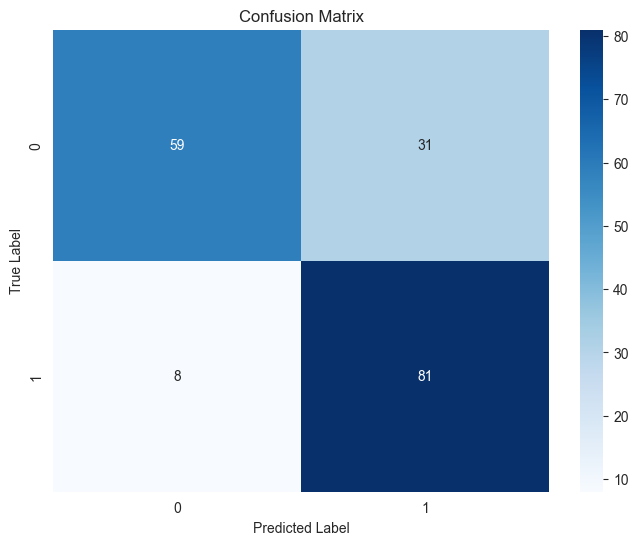

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(X_test_features, dm_test, weights, bias):
    # Get predictions
    with torch.no_grad():
        test_logits = torch.matmul(torch.tensor(X_test_features, dtype=torch.float32), weights) + bias
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).float()

    # Convert to numpy for sklearn metrics
    y_true = dm_test.argmax(axis=1)
    y_pred = test_preds.numpy().argmax(axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return test_probs.numpy()

# Evaluate model
test_probabilities = evaluate_model(X_test_features, dm_test, weights, bias)

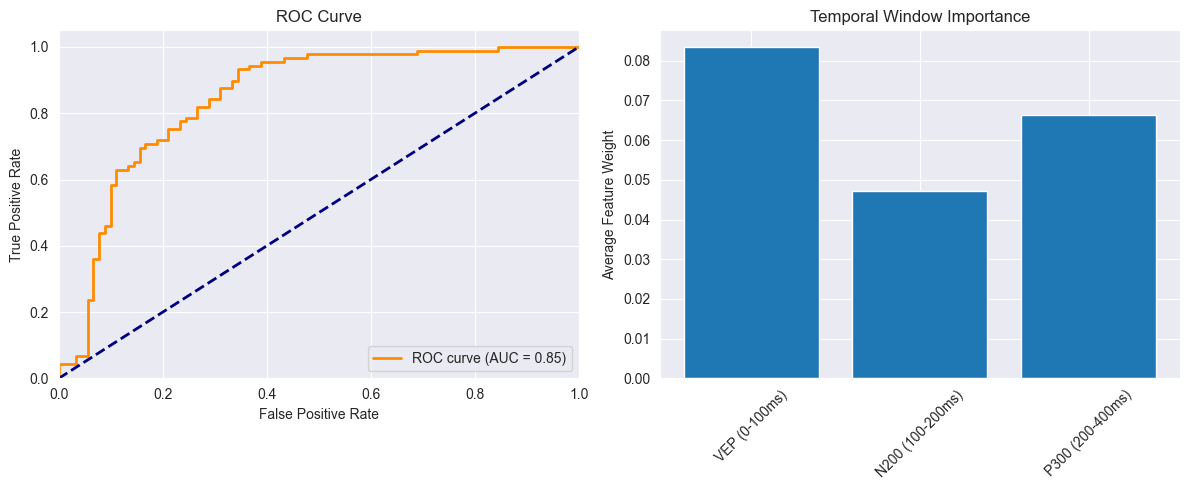

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_model_analysis(X_test_features, dm_test, weights, test_probabilities):
    # ROC Curve
    fpr, tpr, _ = roc_curve(dm_test[:, 1], test_probabilities[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))

    # Plot ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # Feature importance across time windows
    n_channels = 24
    importance = np.abs(weights.numpy()).mean(axis=1)
    window_importance = [
        importance[:n_channels].mean(),  # VEP
        importance[n_channels:2*n_channels].mean(),  # N200
        importance[2*n_channels:].mean()  # P300
    ]

    plt.subplot(1, 2, 2)
    plt.bar(['VEP (0-100ms)', 'N200 (100-200ms)', 'P300 (200-400ms)'],
            window_importance)
    plt.title('Temporal Window Importance')
    plt.ylabel('Average Feature Weight')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_model_analysis(X_test_features, dm_test, weights, test_probabilities)

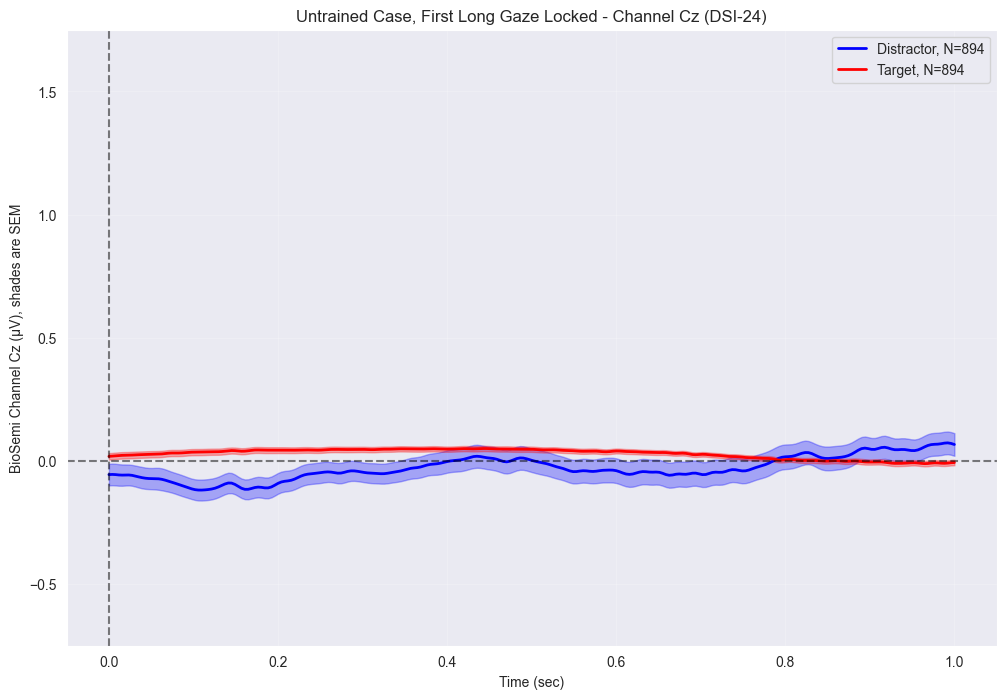

In [6]:
# Let's try with what should be Cz in DSI-24
cz_idx = 12  # DSI-24 typically has Cz around channel 12

def plot_erp_with_sem(X_data, conditions, cz_idx=12):
    """
    Plot ERP with SEM shading for target vs distractor conditions
    Using DSI-24 Cz channel
    """
    X_cz = X_data[:, :, cz_idx]
    time_points = np.linspace(0, 1.0, X_cz.shape[1])

    # Z-score normalize the data
    X_cz = (X_cz - np.mean(X_cz)) / np.std(X_cz)

    target_trials = X_cz[conditions == 1]
    distractor_trials = X_cz[conditions == 0]

    target_mean = np.mean(target_trials, axis=0)
    distractor_mean = np.mean(distractor_trials, axis=0)

    target_sem = np.std(target_trials, axis=0) / np.sqrt(len(target_trials))
    distractor_sem = np.std(distractor_trials, axis=0) / np.sqrt(len(distractor_trials))

    plt.figure(figsize=(12, 8))

    plt.plot(time_points, distractor_mean, color='blue', label=f'Distractor, N={len(distractor_trials)}', linewidth=2)
    plt.fill_between(time_points,
                    distractor_mean - distractor_sem,
                    distractor_mean + distractor_sem,
                    color='blue', alpha=0.3)

    plt.plot(time_points, target_mean, color='red', label=f'Target, N={len(target_trials)}', linewidth=2)
    plt.fill_between(time_points,
                    target_mean - target_sem,
                    target_mean + target_sem,
                    color='red', alpha=0.3)

    plt.title('Untrained Case, First Long Gaze Locked - Channel Cz (DSI-24)')
    plt.xlabel('Time (sec)')
    plt.ylabel('BioSemi Channel Cz (μV), shades are SEM')
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.ylim(-0.75, 1.75)

    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    return plt.gcf()

plot_erp_with_sem(X, conditions)
plt.show()